In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [3]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-5
# Good value: 1e-6

In [4]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0.20221118_14_03_25"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])

model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')

weights_path = model_path + '/weights.h5'

In [6]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [7]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape = IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                   padding = 'same', data_format = 'channels_first')(images)
        x = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                   padding = 'same', data_format = 'channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(x)
        self.encoder = Model(images, z, name = 'encoder')

        latents = Input(shape = LATENT_DIM)
        x = Dense(8 * LATENT_DIM * 32 * 32, activation = None)(latents)
        x = Reshape((8 * LATENT_DIM, 32, 32))(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
                   padding = 'same', data_format = 'channels_first')(x)
        outputs = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')(x)
        self.decoder = Model(latents, outputs, name = 'decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [8]:
model = VAE()
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 127, 127)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 64, 64)         368       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 32, 32)         584       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 8384)              68690112  
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  0         
Total params: 68,691,064
Trainable params: 68,691,064
Non-trainable params: 0
_______________________________________________

In [9]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-37
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [10]:
history = model.fit(x = x_train, y = x_train, epochs = EPOCHS, callbacks = [LR_callback, neptune_callback], validation_data = (x_validation, x_validation), verbose = 1)

Epoch 1/200
313/313 [==============================] - 419s 30ms/step - loss: 0.2036 - val_loss: 0.1560
Epoch 2/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1789 - val_loss: 0.1499
Epoch 3/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1654 - val_loss: 0.1439
Epoch 4/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1490 - val_loss: 0.1426
Epoch 5/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1460 - val_loss: 0.1415
Epoch 6/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1481 - val_loss: 0.1385
Epoch 7/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1390 - val_loss: 0.1441
Epoch 8/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1376 - val_loss: 0.1363
Epoch 9/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1377 - val_loss: 0.1362
Epoch 10/200
313/313 [==============================] - 9s 28ms/step - loss: 0.1

313/313 [==============================] - 9s 28ms/step - loss: 0.0770 - val_loss: 0.1150
Epoch 160/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0760 - val_loss: 0.1107
Epoch 161/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0750 - val_loss: 0.1111
Epoch 162/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0763 - val_loss: 0.1146
Epoch 163/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0743 - val_loss: 0.1127
Epoch 164/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0770 - val_loss: 0.1129
Epoch 165/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0760 - val_loss: 0.1134
Epoch 166/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0759 - val_loss: 0.1118
Epoch 167/200
313/313 [==============================] - 9s 28ms/step - loss: 0.0766 - val_loss: 0.1156
Epoch 168/200
313/313 [==============================] - 9s 28ms/step - loss: 

TypeError: summary() got an unexpected keyword argument 'print_fn'

In [11]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j], cmap = 'afmhot')
            axes[i][j].set_title(f'Generated image {i} band {j}')

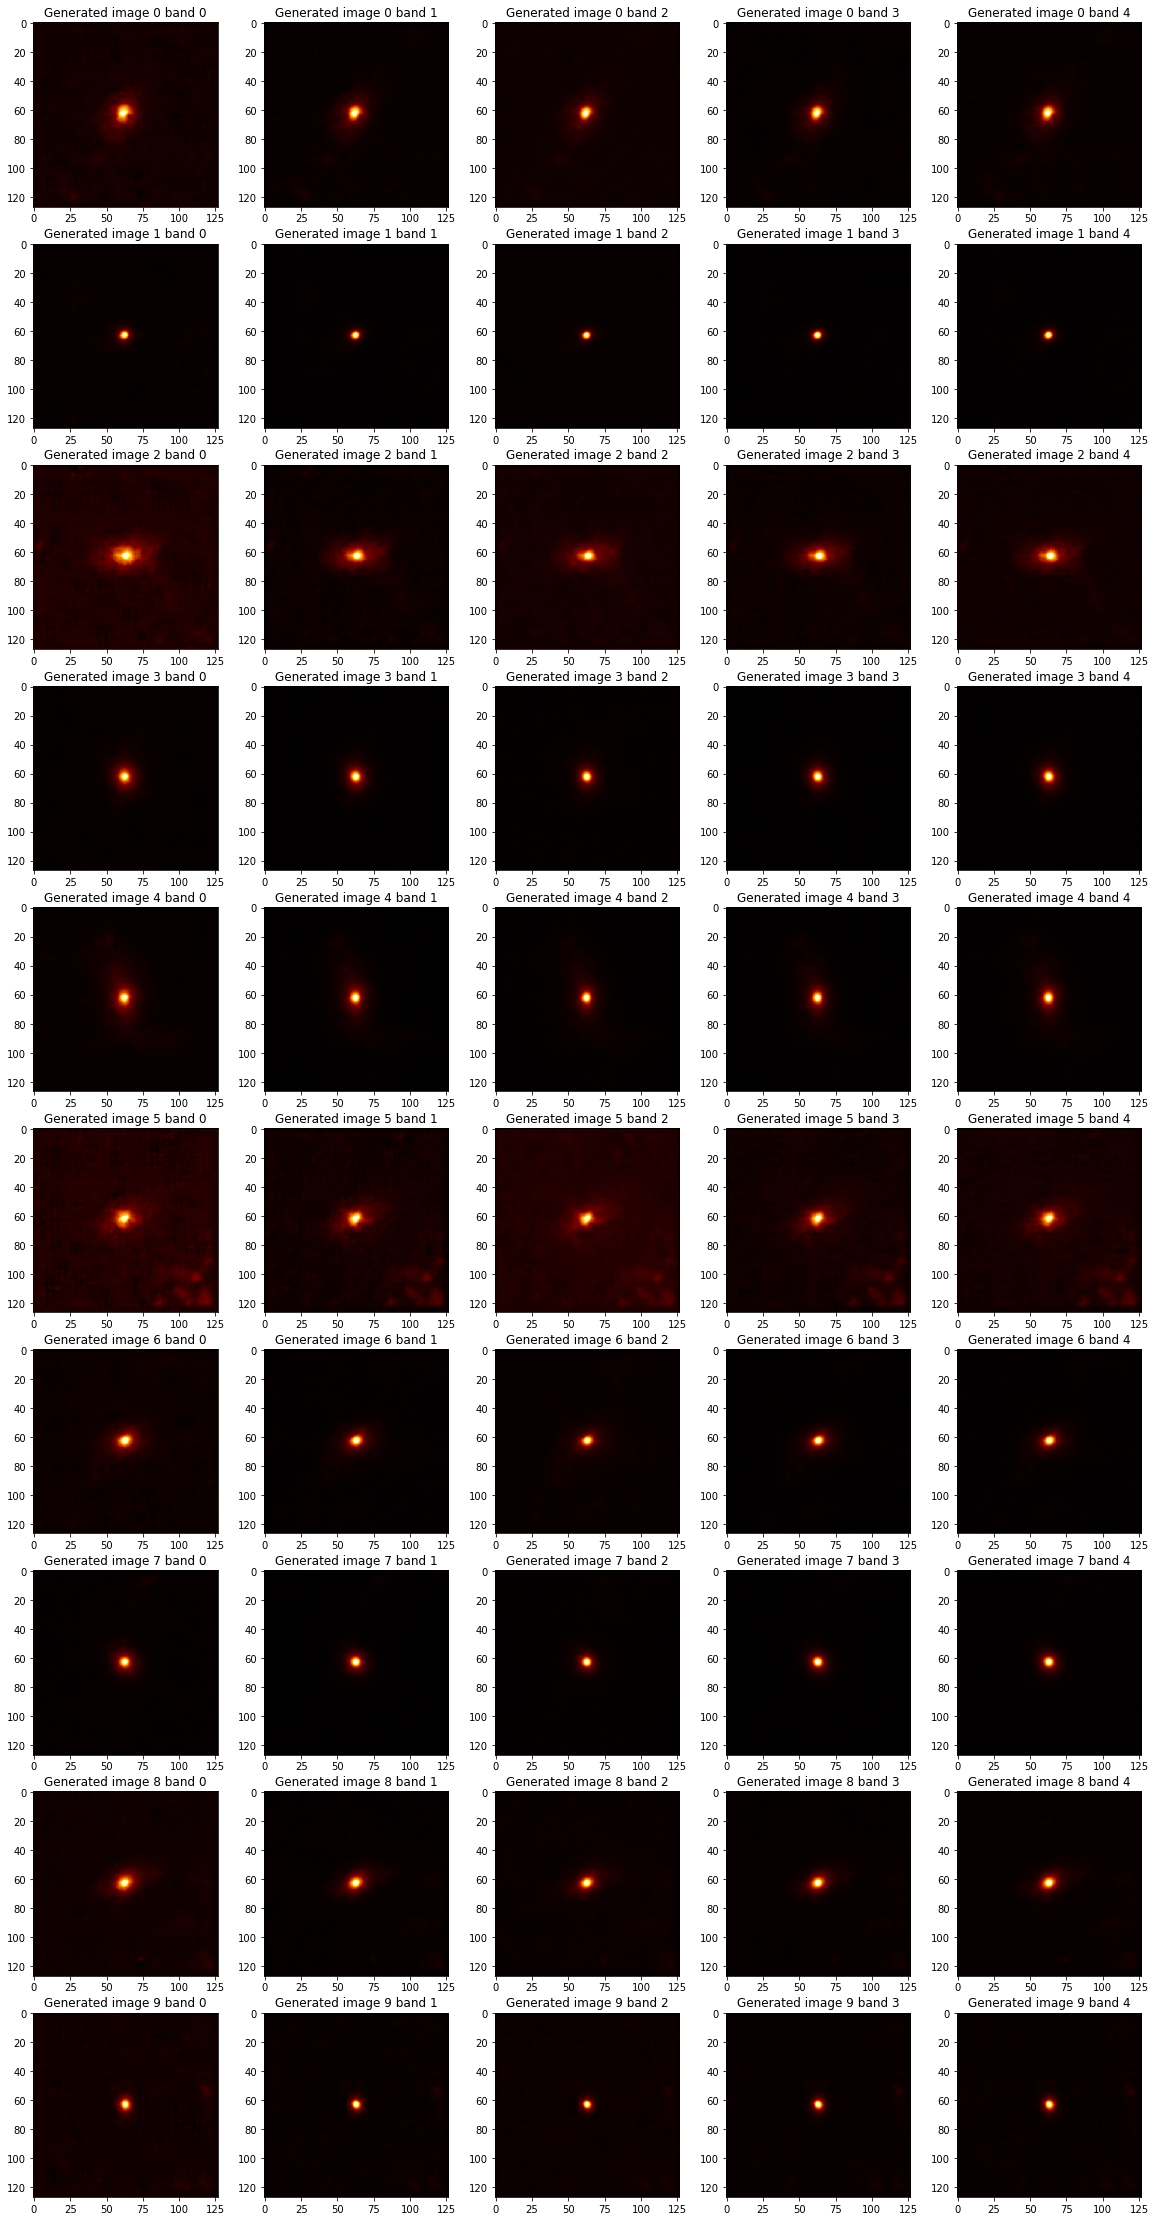

In [15]:
generate_example_galaxies(10)

In [128]:
image_list_g = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/g_band"))
image_list_r = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/r_band"))
image_list_i = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/i_band"))
image_list_z = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/z_band"))
image_list_y = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/y_band"))

photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')
photozdata.describe()

b = np.argsort(photozdata['object_id'])
sorted_photozdata = photozdata.iloc[b][:]
photozdata = sorted_photozdata

hf_in = h5py.File('/mnt/data/HSC/HSC_v6/step3/127x127_in.hdf5', 'a')
hf_out = h5py.File('/mnt/data/HSC/HSC_v6/step3/127x127_out.hdf5', 'a')

In [ ]:
count_in = 0
count_out = 0
size = len(image_list_g)
for i in range(size):
    
    stdout.write("\rChecking %d samples of " % (i + 1) + str(size))
    
    object_id = image_list_g[i][0:17]

    five_band_image = []

    image_g = fits.open("/mnt/data/HSC/HSC_v6/step1/g_band/" + image_list_g[i])
    image_r = fits.open("/mnt/data/HSC/HSC_v6/step1/r_band/" + image_list_r[i])
    image_i = fits.open("/mnt/data/HSC/HSC_v6/step1/i_band/" + image_list_i[i])
    image_z = fits.open("/mnt/data/HSC/HSC_v6/step1/z_band/" + image_list_z[i])
    image_y = fits.open("/mnt/data/HSC/HSC_v6/step1/y_band/" + image_list_y[i])

    image_g_data = image_g[1].data
    image_r_data = image_r[1].data
    image_i_data = image_i[1].data
    image_z_data = image_z[1].data
    image_y_data = image_y[1].data

    pad1 = int((127 - len(image_g_data)) / 2)
    pad2 = 127 - len(image_g_data) - pad1
    pad3 = int((127 - len(image_g_data[0])) / 2)
    pad4 = 127 - len(image_g_data[0]) - pad3


    im_g = np.pad(image_g_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_r = np.pad(image_r_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_i = np.pad(image_i_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_z = np.pad(image_z_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_y = np.pad(image_y_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))

    im = np.true_divide(np.array([im_g, im_r, im_i, im_z, im_y]), max_value)
    loss = model.evaluate(np.array([im]), np.array([im]), verbose = 0)
    
    if loss <= 0.1:
    
        five_band_image.append(im_g)
        five_band_image.append(im_r)
        five_band_image.append(im_i)
        five_band_image.append(im_z)
        five_band_image.append(im_y)

        five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])

        photozdata_subset = photozdata.iloc[i]

        specz = photozdata_subset['specz_redshift']
        specz_reshape = np.reshape(specz, [1, 1])

        if count_in == 0:
        
            for (columnName, columnData) in photozdata.iteritems():
                
                if columnName == 'specz_name' or columnName == 'coord':
                    
                    hf_in.create_dataset(columnName, data = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i], maxshape = (None, ))
                    
                else:
                    
                    hf_in.create_dataset(columnName, data = photozdata[columnName][i : i + 1], maxshape = (None, ))
            
            hf_in.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))

        else:
        
            for (columnName, columnData) in photozdata.iteritems():
        
                hf_in[columnName].resize((hf_in[columnName].shape[0] + 1), axis = 0)
            
                if columnName == 'specz_name' or columnName == 'coord':
                    
                    hf_in[columnName][hf_in[columnName].shape[0] - 1] = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i]
                    
                else:
                    
                    hf_in[columnName][hf_in[columnName].shape[0] - 1] = photozdata[columnName][i : i + 1]
            
            hf_in['image'].resize((hf_in['image'].shape[0] + 1), axis = 0)
            hf_in['image'][hf_in['image'].shape[0] - 1, :, :, :] = five_band_image
        
        count_in = count_in + 1
    
    else:
        
        five_band_image.append(im_g)
        five_band_image.append(im_r)
        five_band_image.append(im_i)
        five_band_image.append(im_z)
        five_band_image.append(im_y)

        five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])

        photozdata_subset = photozdata.iloc[i]

        specz = photozdata_subset["specz_redshift"]
        specz_reshape = np.reshape(specz, [1, 1])

        if count_out == 0:
            
            for (columnName, columnData) in photozdata.iteritems():
                
                if columnName == 'specz_name' or columnName == 'coord':
                    
                    hf_out.create_dataset(columnName, data = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i], maxshape = (None, ))
                    
                else:
                    
                    hf_out.create_dataset(columnName, data = photozdata[columnName][i : i + 1], maxshape = (None, ))
                
            hf_out.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))

        else:
            
            for (columnName, columnData) in photozdata.iteritems():
        
                hf_out[columnName].resize((hf_out[columnName].shape[0] + 1), axis = 0)
            
                if columnName == 'specz_name' or columnName == 'coord':
                    
                    hf_out[columnName][hf_out[columnName].shape[0] - 1] = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i]
                    
                else:
                    
                    hf_out[columnName][hf_out[columnName].shape[0] - 1] = photozdata[columnName][i : i + 1]
                
            hf_out['image'].resize((hf_out['image'].shape[0] + 1), axis = 0)
            hf_out['image'][hf_out["image"].shape[0] - 1, :, :, :] = five_band_image
        
        count_out = count_out + 1

    image_g.close()
    image_r.close()
    image_i.close()
    image_z.close()
    image_y.close()

hf_in.close()
hf_out.close()

Checking 13191 samples of 286401

In [ ]:
print(count_in)

In [ ]:
print(count_out)

In [ ]:
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_in.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]

In [ ]:
hf.close()

In [ ]:
plt.hist(y_array, bins = 100)
plt.show()

In [ ]:
# END